# Example LePHARE run


In this example notebook we demonstrate a run on the CLAUDS data (Desprez et al. 2023) data. This notebook is set in order to show the most basic LePHARE functionalities.

This notebook should demonstrate the procedure for 
* reading/updating the configuration parameters
* creating an input table in the appropriate format
* build the  template library
* run the photo-z
* inspect the results, including the best fit SEDs 

## Load the necessarily packages, including LePHARE

In [1]:
# lephare must be installed if not already
#!pip install lephare 

In [2]:
import lephare as lp
from astropy.table import Table
import numpy as np
from matplotlib import pylab as plt

LEPHAREDIR is being set to the default cache directory:
/Users/rshirley/Library/Caches/lephare/data
More than 1Gb may be written there.
LEPHAREWORK is being set to the default cache directory:
/Users/rshirley/Library/Caches/lephare/work
Default work cache is already linked. 
This is linked to the run directory:
/Users/rshirley/Library/Caches/lephare/runs/20240516T005248


## Load the CLAUDS data

We use photometry from HSC-CLAUDS presented in [Sawicki et al. 2019](https://ui.adsabs.harvard.edu/abs/2019MNRAS.489.5202S/abstract). We limit our example to the use of the ugrizy bands. This includes a sample of AGN that are detected in the X-ray by [Marchesi et al. 2016](https://ui.adsabs.harvard.edu/abs/2016ApJ...817...34M/abstract). Spectroscopic redhsifts are from [Khostovan et al. 2025](https://arxiv.org/abs/2503.00120). These also provide a broad line AGN sample which can be compared and contrasted to X-ray selected AGN.


Our example use an astropy table as input. This can be done using the standard column order:
id, flux0, err0, flux1, err1,..., context, zspec, arbitrary_string. A simple example table with two filters might look like this:
|  id | flux_filt1  |  fluxerr_filt1 |  flux_filt2  |  fluxerr_filt2 | context | zspec | string_data |
|---|---|---|---|---|---|---|---|
|  0 | 1.e-31  | 1.e-32  | 1.e-31  | 2.e-32  | 3 | NaN | "This is just a note" |
|  1 | 2.e-31  |  1.e-32 | 1.e-31  | 2.e-32  |3 | 1. | "This has a specz" |
|  2 | 2.e-31 | 1.e-32  | 2.e-31  | 2.e-32  | 2 | NaN| "This context only uses the second filter" |

The context detemermines which bands are used but can be -99 or a numpy.nan. We do not need to have units on the flux columns but LePHARE assumes they are in erg /s /cm**2 / Hz if we are using fluxes. The number of columns must be two times the number of filters plus the four additional columns.

This input table **must use** the standard column ordering to determine column meaning. This odering depends on the filter order in the config FILTER_LIST value. 

In [3]:
input_lp=Table.read('input_flux_ebv_corrected_20251031.fits')

In [4]:
input_lp[:5]

id,FLUX_APER_2s_u,FLUXERR_APER_2s_u,FLUX_APER_2s_g,FLUXERR_APER_2s_g,FLUX_APER_2s_r,FLUXERR_APER_2s_r,FLUX_APER_2s_i,FLUXERR_APER_2s_i,FLUX_APER_2s_z,FLUXERR_APER_2s_z,FLUX_APER_2s_y,FLUXERR_APER_2s_y,context,specz,string_input,CLASS_STAR_HSC_I
,erg / (Hz s cm2),erg / (Hz s cm2),erg / (Hz s cm2),erg / (Hz s cm2),erg / (Hz s cm2),erg / (Hz s cm2),erg / (Hz s cm2),erg / (Hz s cm2),erg / (Hz s cm2),erg / (Hz s cm2),erg / (Hz s cm2),erg / (Hz s cm2),,,,
int64,float32,float64,float32,float64,float32,float64,float32,float64,float32,float64,float32,float64,int64,float64,bytes6,float32
4808959,5.7268773e-31,5.518034975301129e-32,3.4033537e-30,4.974347995710069e-32,2.0249247e-29,6.132702554394253e-32,6.3775256e-29,7.164708382869701e-32,1.3603414e-28,1.1793449142542687e-31,1.6035619e-28,2.1691132524251114e-31,63,0.97289,galaxy,0.57840824
4142497,4.6692144e-30,8.35349039749749e-32,1.0584889e-29,7.032562540965531e-32,1.3118917e-29,1.1283534924838458e-31,1.6121168e-29,1.280090547837343e-31,1.7818013e-29,1.9356842451688993e-31,1.7054021e-29,4.143978765013208e-31,63,3.74973,broad,0.099020466
4810688,7.382787e-29,6.9711521514209e-32,6.4941014e-28,9.675751207640002e-32,1.8728434e-27,1.6347614145883166e-31,3.8103014e-27,3.20878394975566e-31,5.4658897e-27,3.831841571658854e-31,6.654268e-27,3.98548194889167e-31,63,0.0,galaxy,0.99988246
3817033,3.5629857e-29,6.659804406999169e-32,2.0267107e-28,7.570278434616451e-32,5.8696846e-28,1.0176130568965198e-31,9.194632e-28,1.0529419782610294e-31,1.2421681e-27,1.6188882139810722e-31,1.3697514e-27,2.7597109946110087e-31,63,0.19567,galaxy,0.027599856
4424478,3.417857e-31,6.044610740664273e-32,8.763036e-31,4.354743801808737e-32,1.1540443e-30,5.741448872486873e-32,1.3336459e-30,6.5000303656972e-32,2.1873349e-30,1.0494809229310376e-31,2.3111705e-30,1.974837319678105e-31,63,2.09735,galaxy,0.009102574


Show the different populations of sources present in the catalogue (normal galaxies, x-ray AGN, broad line AGN)

In [5]:
for s in np.unique(input_lp['string_input']):
    print(s, np.sum(input_lp['string_input']==s))

broad 30
galaxy 3872
x 426
x+broa 74


Trim the catalogue to keep only galaxies for the moment

In [6]:
is_galaxy = input_lp['string_input'] == 'galaxy'
galaxy_indices = np.where(is_galaxy)[0]
input_lp_gal = input_lp[galaxy_indices]
# Remove the last column to be in addequation with the required format
keepcols=[s for s in input_lp.colnames if s != "CLASS_STAR_HSC_I"]
input_lp_gal=input_lp_gal[keepcols]

## Update the config

We set up a specific CLAUDS configuration file as a basis. We can update the various keywords in the notebook if desired. 

In [7]:
config = lp.read_config("CLAUDS.para")

# Example of updating one parameter, which is the grid in redshift
config.update({
    'Z_STEP': '0.02,0.,6.',
})

Number of keywords read in the config file: 85


Plot the filters as a sanity check

Text(0, 0.5, 'Transmission')

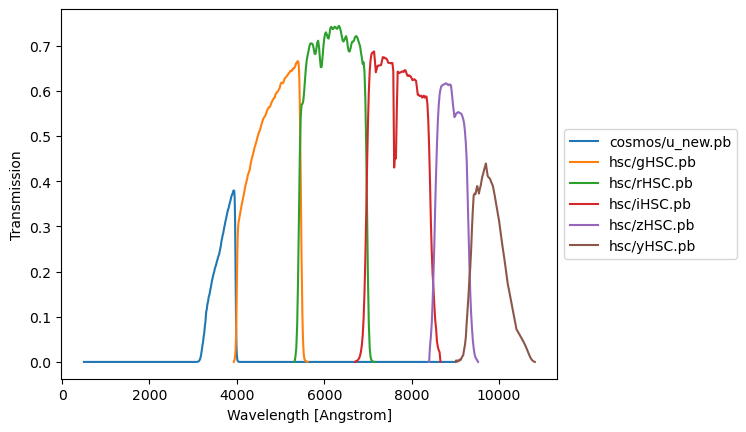

In [8]:
for n, f in enumerate(config['FILTER_LIST'].value.split(',')):
    data = Table.read(f"{lp.LEPHAREDIR}/filt/{f}", format="ascii")
    plt.plot(data[data.colnames[0]], data[data.colnames[1]], label=f)
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.xlabel("Wavelength [Angstrom]")
plt.ylabel("Transmission")

## Download the data required for the run


In [9]:
# If you want all the files with many different filters and templates etc
# lp.data_retrieval.get_auxiliary_data(clone=False)

This function checks that all the necessary data are in LEPHAREDIR. 
It will use the automated download functionality if some files are missing.

In [10]:
# We need to download the required files
lp.data_retrieval.get_auxiliary_data(keymap=config)

Registry file downloaded and saved as data_registry.txt.
Checking/downloading 415 files...
415 completed.
All files downloaded successfully and are non-empty.


## Create the full library of modeled fluxes

These are the key preparatory stages to build the library of modeled fluxes. 
It calculates the filters in the LePHARE format, calculate the library of SEDs and finally calculate the library of magnitudes for all the models. The *prepare* method runs *filter*, *sedtolib*, and *mag_gal* that would be run independently at the command line. These are all explained in detail in the [documentation](https://lephare.readthedocs.io/en/latest/original.html#detailed-lephare-user-manual).

In [11]:
lp.prepare(config,qso_config=None)

# NAME                        IDENT      Lbda_mean Lbeff(Vega)       FWHM     AB-cor    TG-cor      VEGA M_sun(AB)   CALIB      Lb_eff    Fac_corr
u_new.pb                      1             0.3690      0.3750      0.0456    0.6195   -0.2745  -20.8527    6.3135       0      0.3668      1.0000
gHSC.pb                       2             0.4851      0.4760      0.1194   -0.0860   -0.2458  -20.7272    5.0764       0      0.4780      1.0000
rHSC.pb                       3             0.6241      0.6142      0.1539    0.1466    0.2580  -21.5143    4.6523       0      0.6178      1.0000
iHSC.pb                       4             0.7716      0.7637      0.1476    0.3942    0.6138  -22.2286    4.5323       0      0.7666      1.0000
zHSC.pb                       5             0.8915      0.8907      0.0768    0.5169    0.7625  -22.6733    4.5147       0      0.8903      1.0000
yHSC.pb                       6             0.9801      0.9771      0.0797    0.5534    0.7763  -22.9145    4.5081    

## Run the photo-z

Only galaxy and star templates for the mome


In [12]:
config.update({
    'ZPHOTLIB': 'GAL_CLAUDS,STAR_CLAUDS',
})

In [13]:
config.update({
    'AUTO_ADAPT': 'YES',
    'NZ_PRIOR': '4',
})

Finally we run the main fitting process which is equivalent to *zphota* when using the command line. 


In [14]:
output, photozlist=lp.process(config, input_lp_gal,write_outputs=True)

Using user columns from input table assuming they are in the standard order.
Processing 3872 objects with 6 bands
####################################### 
# PHOTOMETRIC REDSHIFT with OPTIONS   # 
# Config file            : 
# CAT_IN                 : bidon
# CAT_OUT                : zphot.out
# CAT_LINES              : 0 1000000000
# PARA_OUT               : /Users/rshirley/Library/Caches/lephare/data/examples/output.para
# INP_TYPE               : F
# CAT_FMT[0:MEME 1:MMEE] : 0
# CAT_MAG                : AB
# ZPHOTLIB               : GAL_CLAUDS STAR_CLAUDS 
# FIR_LIB                : 
# FIR_LMIN               : 7.000000
# FIR_CONT               : -1.000000
# FIR_SCALE              : -1.000000
# FIR_FREESCALE          : YES
# FIR_SUBSTELLAR         : NO
# ERR_SCALE              : 0.020000 0.020000 0.020000 0.020000 0.020000 0.020000 
# ERR_FACTOR             : 1.500000 
# GLB_CONTEXT            : 0
# FORB_CONTEXT           : -1
# DZ_WIN                 : 1.000000
# MIN_THRES           

## Take a quick look at the output

You can see the main columns present int he output. Some columns regarding phsyical parameters are not present because we have not computed them in a standard run. you can see an example [here](https://lephare.readthedocs.io/en/latest/notebooks/Typical_use_case_physicalParameters.html) for computing them.

In [15]:
output[:5]

IDENT,Z_BEST,Z_BEST68_LOW,Z_BEST68_HIGH,Z_MED,Z_MED68_LOW,Z_MED68_HIGH,CHI_BEST,MOD_BEST,EXTLAW_BEST,EBV_BEST,Z_SEC,CHI_SEC,MOD_SEC,EBV_SEC,ZQ_BEST,CHI_QSO,MOD_QSO,MOD_STAR,CHI_STAR,MAG_OBS(),ERR_MAG_OBS(),K_COR(),MAG_ABS(),EMAG_ABS(),MABS_FILT(),SCALE_BEST,NBAND_USED,CONTEXT,ZSPEC,AGE_BEST,AGE_INF,AGE_MED,AGE_SUP,LDUST_BEST,LDUST_INF,LDUST_MED,LDUST_SUP,LUM_TIR_BEST,LUM_TIR_INF,LUM_TIR_MED,LUM_TIR_SUP,MASS_BEST,MASS_INF,MASS_MED,MASS_SUP,SFR_BEST,SFR_INF,SFR_MED,SFR_SUP,SSFR_BEST,SSFR_INF,SSFR_MED,SSFR_SUP,COL1_INF,COL1_MED,COL1_SUP,COL2_INF,COL2_MED,COL2_SUP,LUM_NUV_BEST,LUM_R_BEST,LUM_K_BEST,MAG_PRED(),STRING_INPUT,BAY_ZG
str7,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,float64,float64,float64,int64,int64,float64,float64[6],float64[6],float64[6],float64[6],float64[6],float64[6],float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64[0],str6,float64[301]
4808959,0.872555284225674,0.8383811168862189,0.8845490164157491,0.8673788426085923,0.842304801798071,0.8983269534393117,5.61075526320733,6,1.0,0.0,-99.9,-99.0,-99,-99.0,-99.9,1000000000.0,-99,197,168.30029462698622,26.98990484038066 .. 20.880022893102428,0.15980078280528637 .. 0.03008081637103954,3.63176761098432 .. 0.4856125347850542,-20.357647065546036 .. -23.34029113727498,0.4973692565631538 .. 1.8524979606391554,2.0 .. 5.0,375.58047231623476,6,0,0.97289,-999.0,-99.9,-99.9,-99.9,-999.0,-99.9,-99.9,-99.9,-999.0,-99.9,-99.9,-99.9,-999.0,-99.9,-99.9,-99.9,-999.0,-99.9,-99.9,-99.9,-999.0,-99.9,-99.9,-99.9,-99.9,-99.9,-99.9,-99.9,-99.9,-99.9,8.267507956718386,9.995169662093726,9.489428541272101,,galaxy,0.0 .. 0.0
4810688,0.42080698417152673,0.41449773819597474,0.42646826431425405,0.4248556868364386,0.4061173997564709,0.4478517980061215,77.07454550260427,6,1.0,0.0,-99.9,-99.0,-99,-99.0,-99.9,1000000000.0,-99,112,68.31139923946502,21.714148684027087 .. 16.834986453535993,0.03003940707648257 .. 0.03000015865393836,2.107255921570136 .. 0.1912710249894426,-22.412167707771776 .. -25.068996057330544,0.44071693455009786 .. 1.2482503955225646,1.0 .. 4.0,1908.6292618885673,6,0,0.0,-999.0,-99.9,-99.9,-99.9,-999.0,-99.9,-99.9,-99.9,-999.0,-99.9,-99.9,-99.9,-999.0,-99.9,-99.9,-99.9,-999.0,-99.9,-99.9,-99.9,-999.0,-99.9,-99.9,-99.9,-99.9,-99.9,-99.9,-99.9,-99.9,-99.9,8.973526530827153,10.70118823620249,10.195447115380869,,galaxy,0.0 .. 0.0
3817033,0.22158385919177725,0.21737288578250566,0.22361592348198803,0.22654469502577151,0.20828738463537264,0.3005650788466291,15.099772817967201,7,1.0,0.0,-99.9,-99.0,-99,-99.0,-99.9,1000000000.0,-99,109,229.68553221458515,22.505164322873636 .. 18.551132811274346,0.03015412444941693 .. 0.030001795236263715,0.9201277061661407 .. 0.12474705374219414,-18.77594157544837 .. -21.77941206273713,0.4958116289655141 .. 0.6164075430332403,1.0 .. 5.0,79.21786286849392,6,0,0.19567,-999.0,-99.9,-99.9,-99.9,-999.0,-99.9,-99.9,-99.9,-999.0,-99.9,-99.9,-99.9,-999.0,-99.9,-99.9,-99.9,-999.0,-99.9,-99.9,-99.9,-999.0,-99.9,-99.9,-99.9,-99.9,-99.9,-99.9,-99.9,-99.9,-99.9,7.568250244025254,9.348661627123867,8.876399768128785,,galaxy,3.677622140676668e-97 .. 0.0
4424478,2.2318816670930848,2.1489449291197222,2.324477273547958,2.209010385197689,2.0195354322076287,2.3288073962471794,3.864236388676725,29,4.0,0.4,0.42,31.0,31,0.35,-99.9,1000000000.0,-99,71,24.12007434356711,27.55031480442404 .. 25.483157257805743,0.2896526476542852 .. 0.14239017501346732,1.5143607539334003 .. 0.9666666386643376,-20.092796031853478 .. -21.7316498493912,1.011549249869228 .. 4.580280846057285,5.0 .. 5.0,1539.9492728140665,6,0,2.09735,-999.0,-99.9,-99.9,-99.9,-999.0,-99.9,-99.9,-99.9,-999.0,-99.9,-99.9,-99.9,-999.0,-99.9,-99.9,-99.9,-999.0,-99.9,-99.9,-99.9,-999.0,-99.9,-99.9,-99.9,-99.9,-99.9,-99.9,-99.9,-9

## Investigate the results

Here are some quick checks of the results

Text(0, 0.5, '$z_{phot}$')

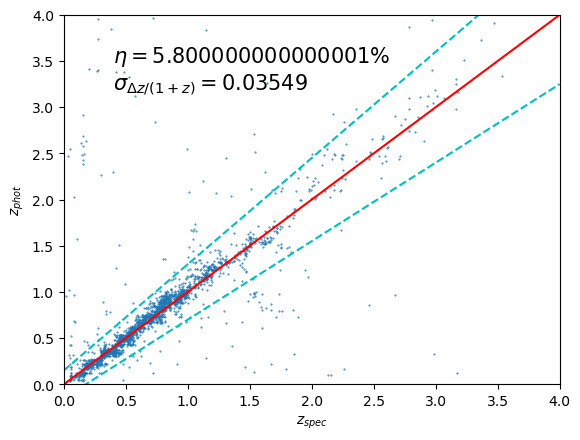

In [16]:
z_max=4
plt.axis([0,z_max,0,z_max])

gal = (output['ZSPEC']>0.002) & (output['ZSPEC']<z_max) & (output['Z_BEST']>0.002) & (output['Z_BEST']<z_max)
zphot = output['Z_BEST'][gal]
zspec = output['ZSPEC'][gal]
plt.scatter(zphot,zspec,s=0.2)

#Trace the limits 0.15(1+z)
x_zs = np.array([0,z_max])
plt.plot(x_zs, x_zs*1.15+0.15, 'c--')
plt.plot(x_zs, x_zs, 'r-')
plt.plot(x_zs, x_zs*0.85-0.15, 'c--')

# Statistics
delz_norm=(zphot-zspec)/(1+zspec)
delz_norm2= delz_norm-np.median(delz_norm)
nmad = 1.48*np.median(np.abs(delz_norm2))
cond_outl = ( abs(delz_norm) > 0.15 )
outl_rate = len(delz_norm[cond_outl]) / float(len(delz_norm))
plt.annotate(r'$\eta  ='+str(100*round(outl_rate,3))+'  \%$\n'+'$ \sigma_{\Delta z /(1+z)}  = '+str(round(nmad,5))+'$',xy=(0.1*z_max,0.8*z_max),color="black", fontsize=15)

plt.xlabel("$z_{spec}$")
plt.ylabel("$z_{phot}$")

Text(0.5, 0, '$z$')

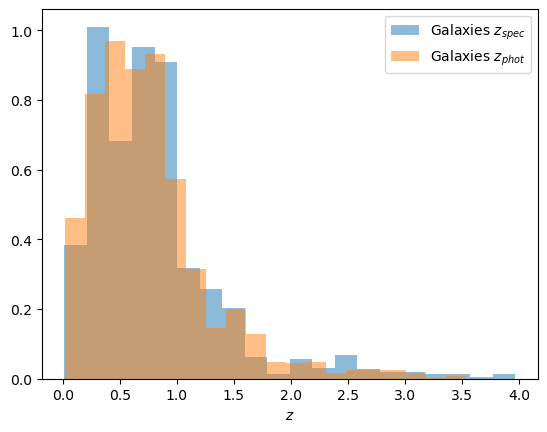

In [17]:
plt.hist(output['ZSPEC'][gal],bins=20,density=True,label='Galaxies $z_{spec}$',alpha=0.5)
plt.hist(output['Z_BEST'][gal],bins=20,density=True,label='Galaxies $z_{phot}$',alpha=0.5)
plt.legend()
plt.xlabel('$z$')

File: save_spec/Id2923782.spec
File: save_spec/Id3673719.spec
File: save_spec/Id4035610.spec
File: save_spec/Id4002133.spec
File: save_spec/Id3017802.spec
File: save_spec/Id2941517.spec
File: save_spec/Id4405831.spec
File: save_spec/Id2828613.spec
File: save_spec/Id4182242.spec
File: save_spec/Id4437556.spec


/Users/rshirley/Documents/github/lincc/lephare/src/lephare/_spec.py:195: RuntimeWarning: invalid value encountered in divide
  poscond = np.where((zpdf[1, :] / max(zpdf[1, :]) > 0.002) | (zpdf[2, :] / max(zpdf[2, :]) > 0.002))
/Users/rshirley/Documents/github/lincc/lephare/src/lephare/_spec.py:199: RuntimeWarning: invalid value encountered in divide
  ax2.plot(zpdf[0, :], zpdf[2, :] / max(zpdf[2, :]), color="k", linestyle="dashed", label="P(z) Profile")


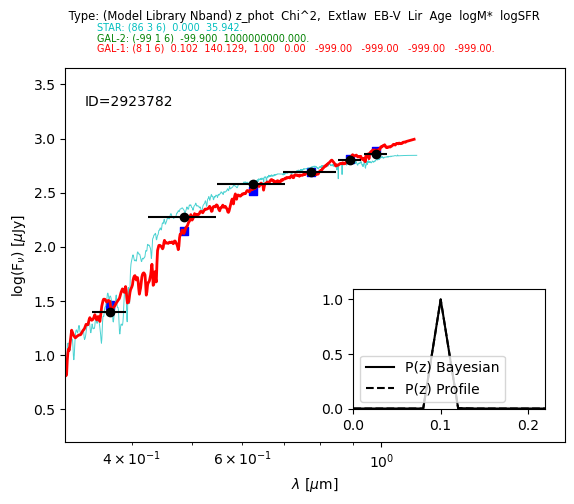

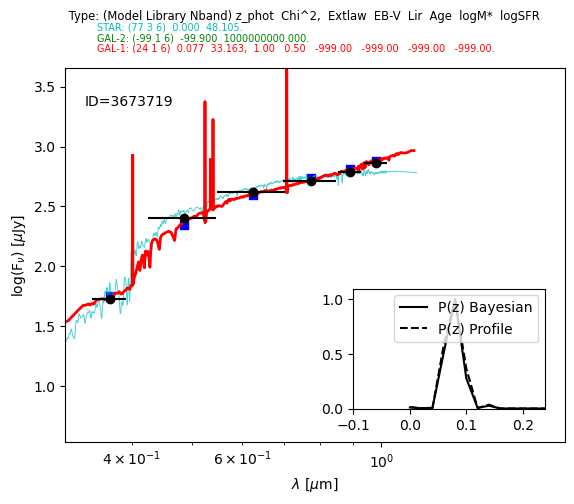

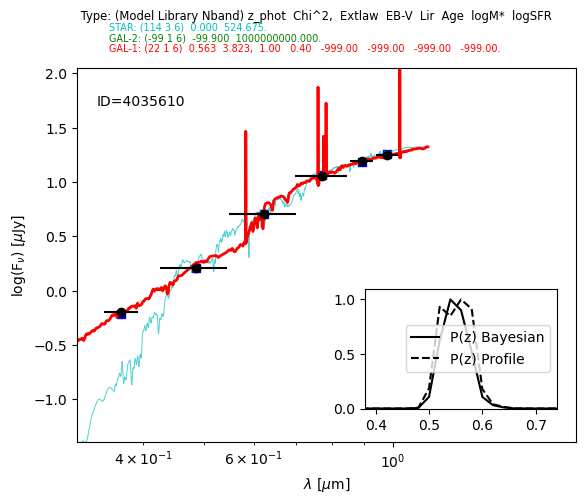

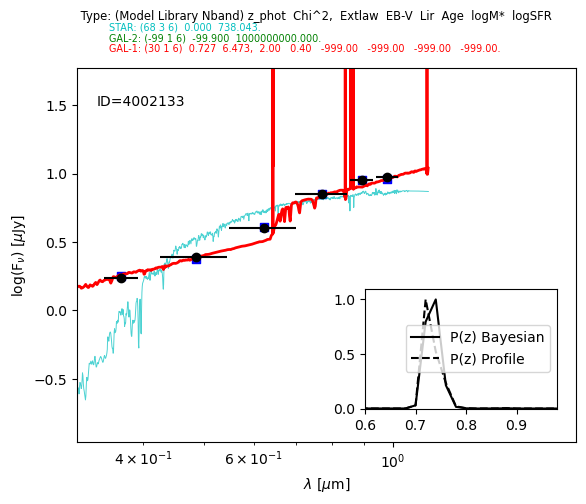

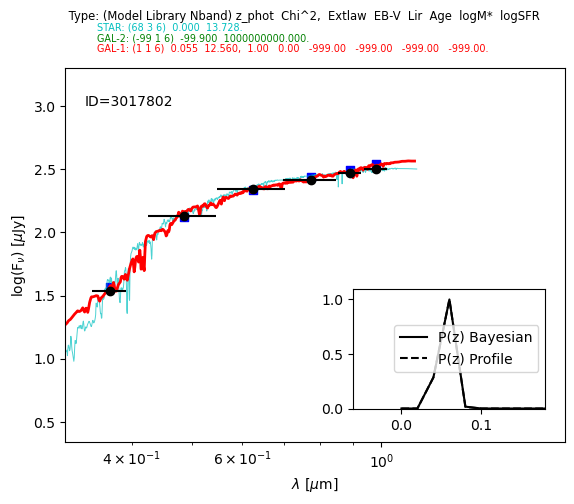

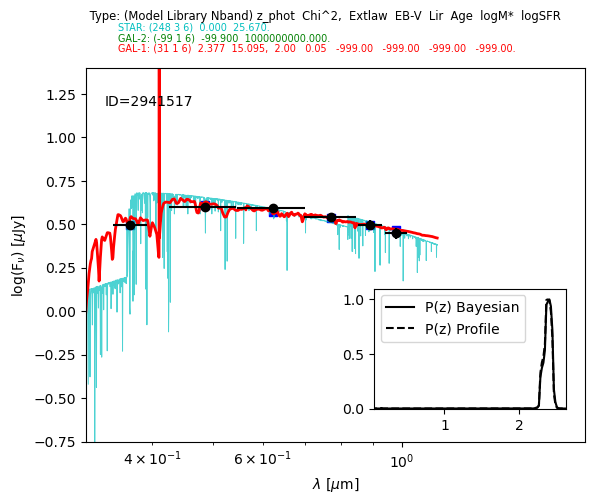

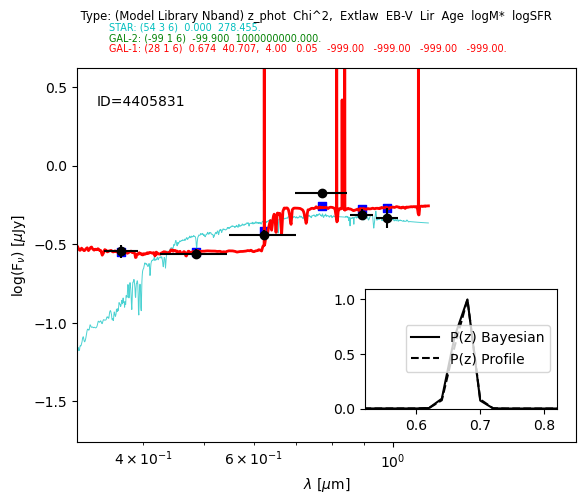

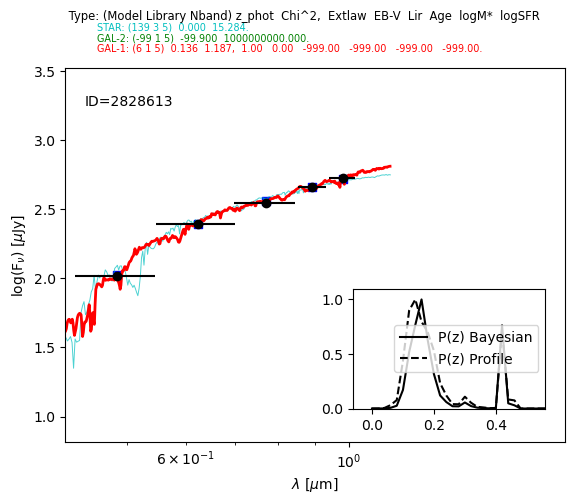

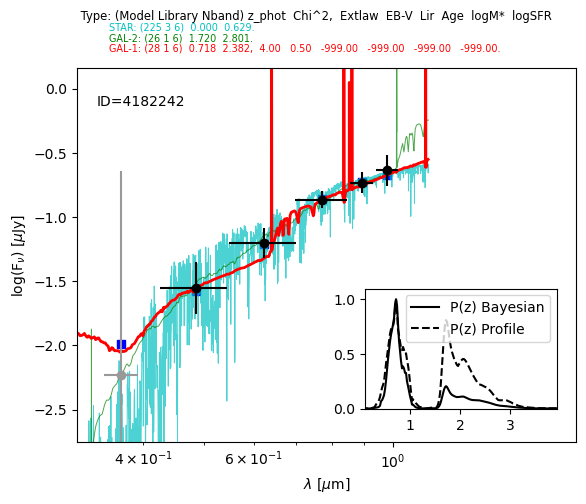

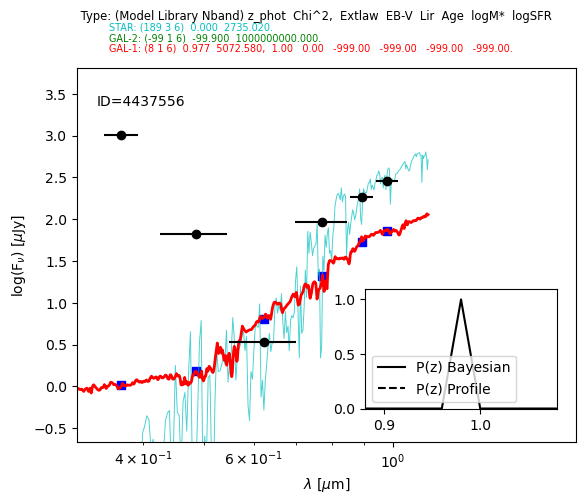

In [18]:
#gal
from os import listdir
from os.path import isfile, join

listname = [f for f in listdir("save_spec") if isfile(join("save_spec", f))]
# Lets just look at the top 10
for namefile in listname[:10]:
    lp.plotspec("save_spec/" + str(namefile))